In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

In [2]:
#CSV_PATHS = 'https://scandeval.com/{language}-nlg.csv'
CSV_PATHS = str(Path.home() / "gitsky" / "scandeval.com" / "{language}-nlg-test.csv")
CSV_PATHS

'/Users/dan/gitsky/scandeval.com/{language}-nlg-test.csv'

In [38]:
LANGUAGES = ['danish', 'norwegian', 'swedish', 'german', 'dutch', 'english']

In [39]:
gpt4_models = {
    "gpt-4-0613": "gpt-4",
    "gpt-4-1106-preview": "gpt-4-turbo",
    "gpt-4o-2024-05-13": "gpt-4o",
}

all_models = list(gpt4_models.keys())
all_new_models = list(gpt4_models.values())

results_dict = dict()
for language in LANGUAGES:
    df = (
        pd
        .read_csv(CSV_PATHS.format(language=language))
        .query('merge == False')
        .set_index('model_id')
    )
    df.index = df.index.map(lambda x: re.sub('\(.*\)', '', x).strip())
    scores = df['rank']

    for model in gpt4_models:
        if model not in scores:
            scores.loc[model] = scores.loc[list(gpt4_models.keys())[0]]
            
    scores = scores.loc[all_models]
    results_dict[language] = scores.tolist()

df = pd.DataFrame(results_dict, index=all_new_models)
df

,danish,norwegian,swedish,german,dutch,english
gpt-4,1.12,1.18,1.19,1.18,1.14,1.22
gpt-4-turbo,1.19,1.27,1.27,1.33,1.45,1.16
gpt-4o,1.23,1.33,1.25,1.44,1.54,1.36


In [40]:
gpt4_values = df.loc[list(gpt4_models.values())[0]]
gpt4_values

danish       1.12
norwegian    1.18
swedish      1.19
german       1.18
dutch        1.14
english      1.22
Name: gpt-4, dtype: float64

In [41]:
gpt4_df = df.loc[list(gpt4_models.values())]
gpt4_df = gpt4_values - gpt4_df
gpt4_df["germanic"] = gpt4_df.drop(columns="english").mean(axis=1)
gpt4_df

,danish,norwegian,swedish,german,dutch,english,germanic
gpt-4,0.00,0.00,0.00,0.00,0.00,0.00,0.000
gpt-4-turbo,-0.07,-0.09,-0.08,-0.15,-0.31,0.06,-0.140
gpt-4o,-0.11,-0.15,-0.06,-0.26,-0.40,-0.14,-0.196


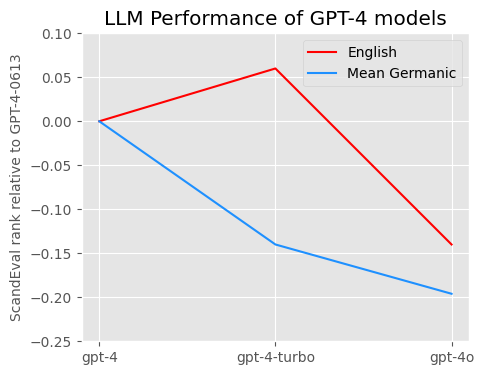

In [42]:
plt.figure(figsize=(5,4))

plt.plot(gpt4_df.english, label="English", color='red')
plt.plot(gpt4_df.germanic, label="Mean Germanic", color='dodgerblue')

plt.title("LLM Performance of GPT-4 models")
plt.ylim(-0.25, 0.1)
plt.ylabel('ScandEval rank relative to GPT-4-0613', fontsize=10)
plt.legend()

plt.savefig('gpt4-drop.png', bbox_inches="tight", dpi=300)
plt.show()